Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [36]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [101]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [102]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Чем больше размер батча - тем быстрее сходимость. Большее кол-во объъктов в данных вероятнее содерржит более репрезентативную информацию о данных. Когда же объектов в батче мало - вплоть до одного, модель уязвимее от шумовых объектов -> отклоняемся от направления оптимума. 

Посмотрим на какую-нибудь картинку:

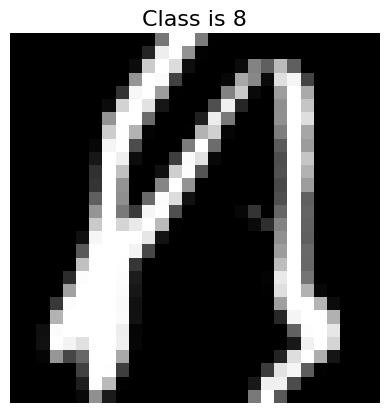

In [103]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

In [39]:
def plot_mnist(mnist_data = trainset):
    # Plot 10 random images from the dataset
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))
    axs = axs.ravel()
    
    for i in range(10):
        rand_idx = torch.randint(len(mnist_data), size=(1,)).item()
        img, label = mnist_data[rand_idx]
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].set_title(f'Label: {label}')
        axs[i].axis('off')

    plt.show()

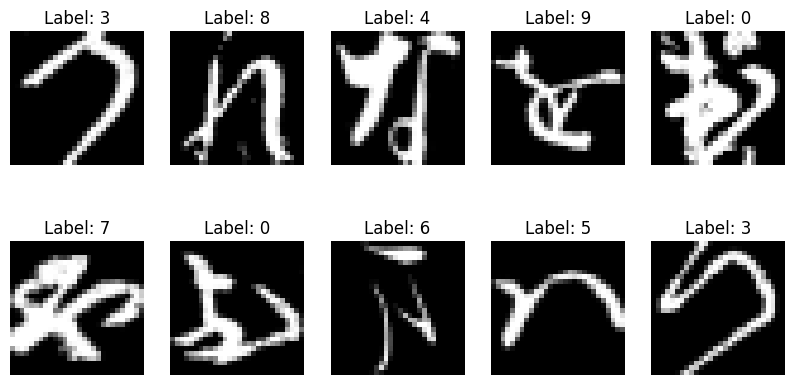

In [8]:
plot_mnist()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [104]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self, func_act):
        super().__init__() # конструктор
        self.backbone = nn.Sequential(
          nn.Linear(28*28, 256),
          func_act(),
          nn.Linear(256, 2128),
          func_act(), 
          nn.Linear(2128, 10), )

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        logits = self.backbone(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**
((28*28)+1) * 256 + ((256)+1) * 2128 + ((2128)+1) * 10

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [105]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images = images.flatten(1, -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [106]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda:0


In [107]:
# Создадим объект модели
model = FCNet(nn.ReLU).to(DEVICE)
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [108]:
from tqdm import tqdm

In [109]:
def training(loss_function, optimizer, model, trainloader, testloader):
  n_epochs = 10
  train_loss = []
  test_loss = []
  for _ in tqdm(range(n_epochs)):
      train_epoch_loss = 0
      for batch in trainloader:
          optimizer.zero_grad()
          features, labels = batch
          features, labels = features.to(DEVICE), labels.to(DEVICE)
          features = features.flatten(1, -1)
          logits = model(features)
          loss = loss_function(logits, labels)
          loss.backward()
          optimizer.step()
          train_epoch_loss += loss.item()
      train_epoch_loss /= len(trainloader)
      train_loss.append(train_epoch_loss)
      model.eval()
      test_epoch_loss = 0
      with torch.no_grad():
        for batch in testloader:
          features, labels = batch
          features, labels = features.to(DEVICE), labels.to(DEVICE)
          features = features.flatten(1, -1)
          logits = model(features)
          loss = loss_function(logits, labels)
          test_epoch_loss += loss.item()
        test_epoch_loss /= len(testloader)
        test_loss.append(test_epoch_loss)
  return train_loss, test_loss



In [111]:
train_loss, test_loss = training(loss_function, optimizer, model, trainloader, testloader)

100%|██████████| 10/10 [01:35<00:00,  9.59s/it]


In [112]:
def plot_line(train_loss, test_loss):
    plt.plot(train_loss, label = "train_loss")
    plt.plot(test_loss, label = "test_loss")
    plt.legend()
    plt.show()

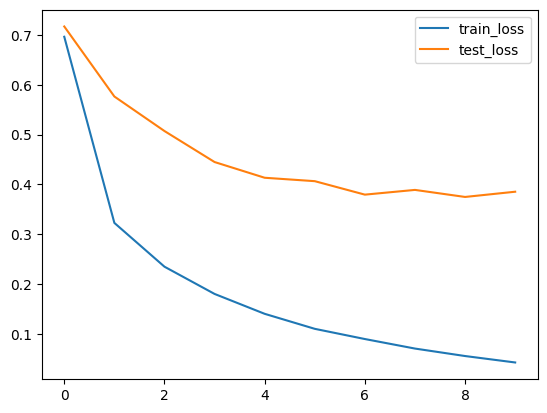

In [113]:
plot_line(train_loss, test_loss)

In [114]:
model.cpu()

FCNet(
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2128, out_features=10, bias=True)
  )
)

In [115]:
get_accuracy(model, testloader)

0.9014

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [116]:
len(trainset)

60000

In [117]:
pixels = []
for img, _ in trainset:
  #img = img.flatten(1, )
  pixels.append(img)

In [118]:
pixels = torch.cat(pixels, axis = 0)

In [119]:
pixels = torch.unsqueeze(pixels, 1)

In [120]:
pixels.shape

torch.Size([60000, 1, 28, 28])

In [121]:
std = torch.std(pixels, [0, 2, 3])

In [122]:
mean = torch.mean(pixels, [0, 2, 3])

In [123]:
std, mean

(tensor([0.3483]), tensor([0.1918]))

In [124]:


transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

In [130]:
model = FCNet(nn.ReLU).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [131]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [132]:
DEVICE

'cuda:0'

In [133]:
train_loss, test_loss = training(loss_function, optimizer, model, trainloader, testloader)

100%|██████████| 10/10 [02:28<00:00, 14.89s/it]


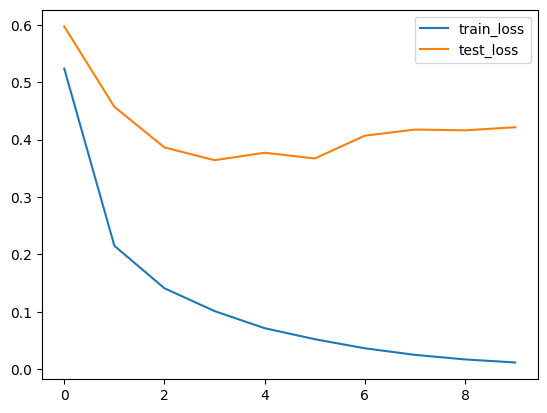

In [134]:
plot_line(train_loss, test_loss)

In [135]:
model.cpu()

FCNet(
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2128, out_features=10, bias=True)
  )
)

In [136]:
get_accuracy(model, testloader)

0.9092

Как изменилась `accuracy` после нормализации?

Немного увеличилась. С 0.9014 до 0.9092

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [58]:
model = FCNet(nn.Sigmoid).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [59]:
## YOUR CODE HERE
train_loss, test_loss = training(loss_function, optimizer, model, trainloader, testloader)

100%|██████████| 10/10 [02:18<00:00, 13.86s/it]


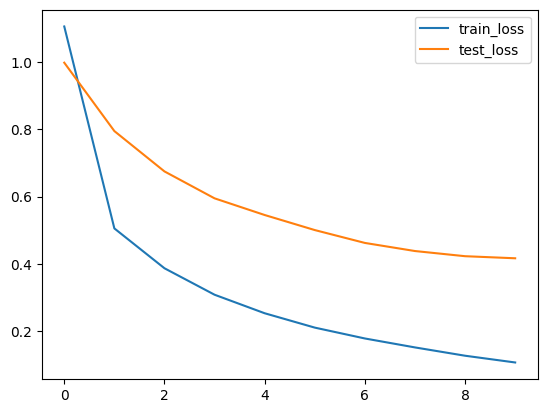

In [60]:
plot_line(train_loss, test_loss)

In [61]:
model.cpu()

FCNet(
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=2128, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=2128, out_features=10, bias=True)
  )
)

In [62]:
get_accuracy(model, testloader)

0.8782

In [ ]:
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(0.79788456 * (x + 0.044715 * torch.pow(x, 3))))


In [ ]:
model = FCNet(GELU).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
train_loss, test_loss = training(loss_function, optimizer, model, trainloader, testloader)

100%|██████████| 10/10 [02:36<00:00, 15.68s/it]


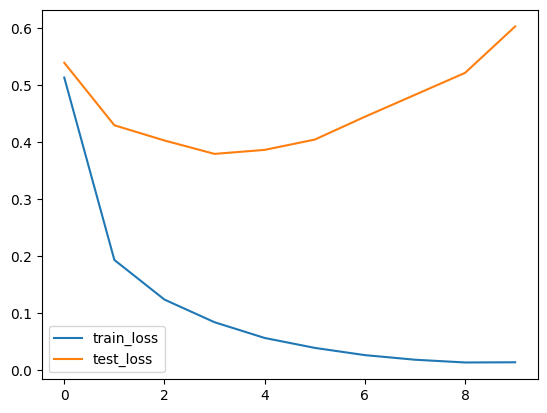

In [ ]:
plot_line(train_loss, test_loss)

In [ ]:
model.cpu()

FCNet(
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): GELU()
    (2): Linear(in_features=256, out_features=2128, bias=True)
    (3): GELU()
    (4): Linear(in_features=2128, out_features=10, bias=True)
  )
)

In [ ]:
get_accuracy(model, testloader)

0.8878

In [ ]:
model = FCNet(nn.Tanh).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
train_loss, test_loss = training(loss_function, optimizer, model, trainloader, testloader)

100%|██████████| 10/10 [02:33<00:00, 15.32s/it]


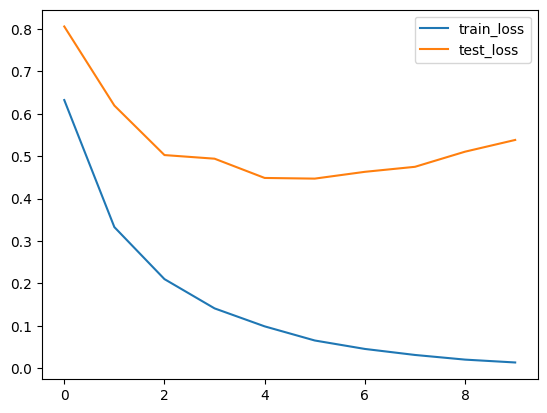

In [ ]:
plot_line(train_loss, test_loss)

In [ ]:
model.cpu()

FCNet(
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=2128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=2128, out_features=10, bias=True)
  )
)

In [ ]:
get_accuracy(model, testloader)

0.8826

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

__nn.Relu__  > 0.9


### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [138]:
model = FCNet(nn.ReLU).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=3e-4)

In [139]:
train_loss, test_loss = training(loss_function, optimizer, model, trainloader, testloader)

100%|██████████| 10/10 [02:43<00:00, 16.32s/it]


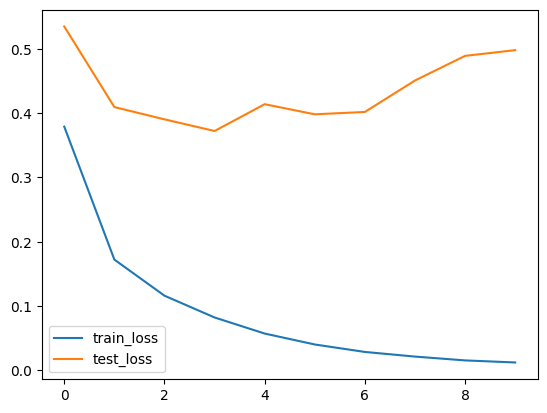

In [140]:
plot_line(train_loss, test_loss)

In [141]:
model.cpu()

FCNet(
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2128, out_features=10, bias=True)
  )
)

In [142]:
get_accuracy(model, testloader)

0.9056

In [143]:
model = FCNet(nn.ReLU).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=3e-4)

In [144]:
train_loss, test_loss = training(loss_function, optimizer, model, trainloader, testloader)

100%|██████████| 10/10 [02:34<00:00, 15.47s/it]


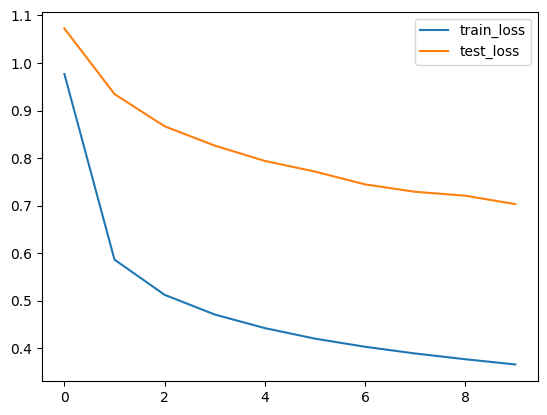

In [145]:
plot_line(train_loss, test_loss)

In [146]:
model.cpu()

FCNet(
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2128, out_features=10, bias=True)
  )
)

In [147]:
get_accuracy(model, testloader)

0.7715

Оптимизатор Adam - показывет лучшие результаты: 0.9092

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [149]:
class CustomReLU(nn.Module):
  
    def forward(self, x):
        x[x < 0] = 0
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [150]:
model = FCNet(CustomReLU).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [151]:
train_loss, test_loss = training(loss_function, optimizer, model, trainloader, testloader)

100%|██████████| 10/10 [02:32<00:00, 15.20s/it]


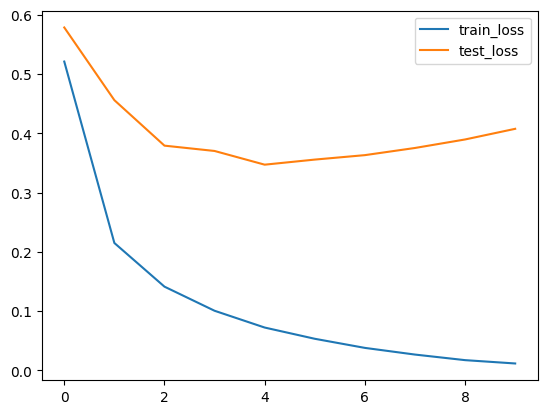

In [152]:
plot_line(train_loss, test_loss)

In [153]:
model.cpu()

FCNet(
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): CustomReLU()
    (2): Linear(in_features=256, out_features=2128, bias=True)
    (3): CustomReLU()
    (4): Linear(in_features=2128, out_features=10, bias=True)
  )
)

В моем коде я не могу заменить нелинейную функцию уже обученной модели,  поскольку они идет в конструктор класса, при вызове веса инициализируются случайно. Поэтому обучу с Custom Relu c ожиданием что метрика будет примерно такая же как с Relu





In [154]:
get_accuracy(model, testloader)   

0.9093

C nn Relu было 0.9092 

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Да уж - до Mdjourney далеко

'Сгененируй работающего ML-инженера' 

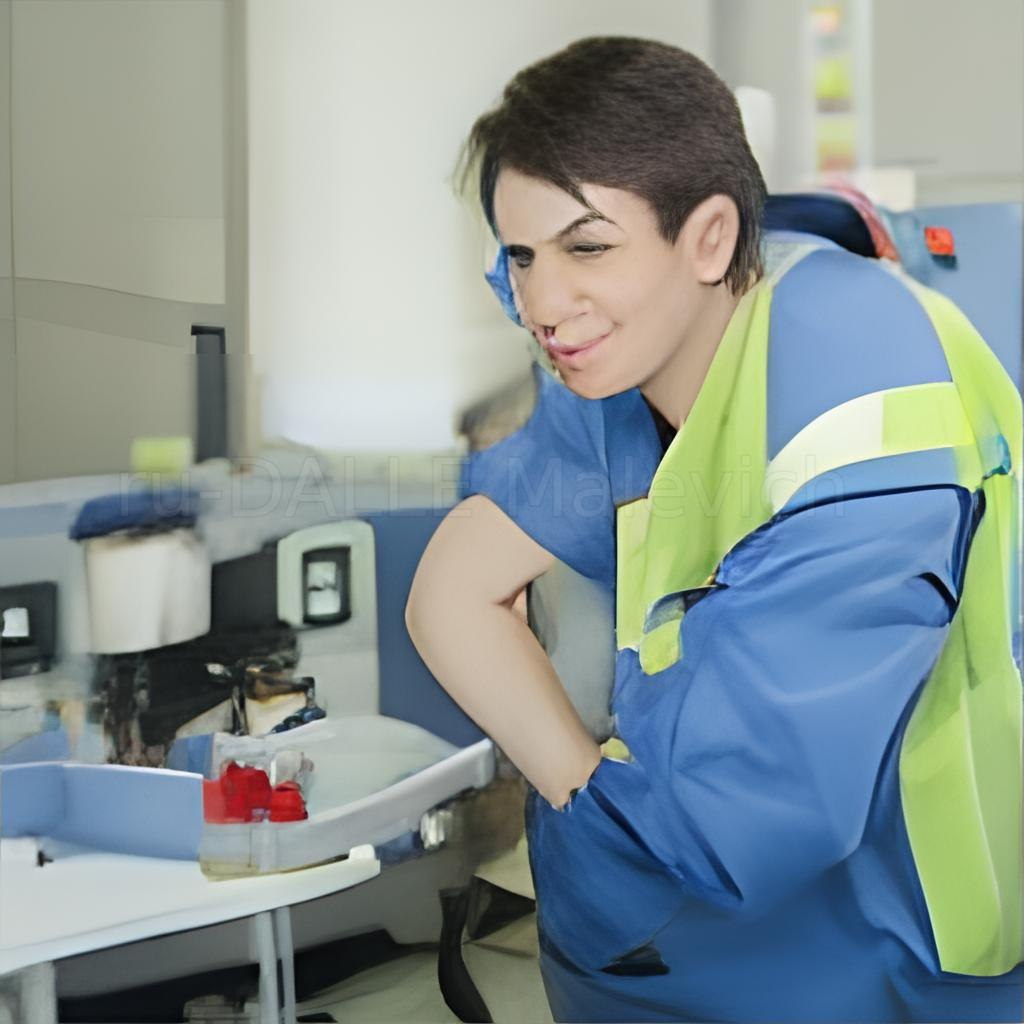

"Весенний сибирский солнечный день"

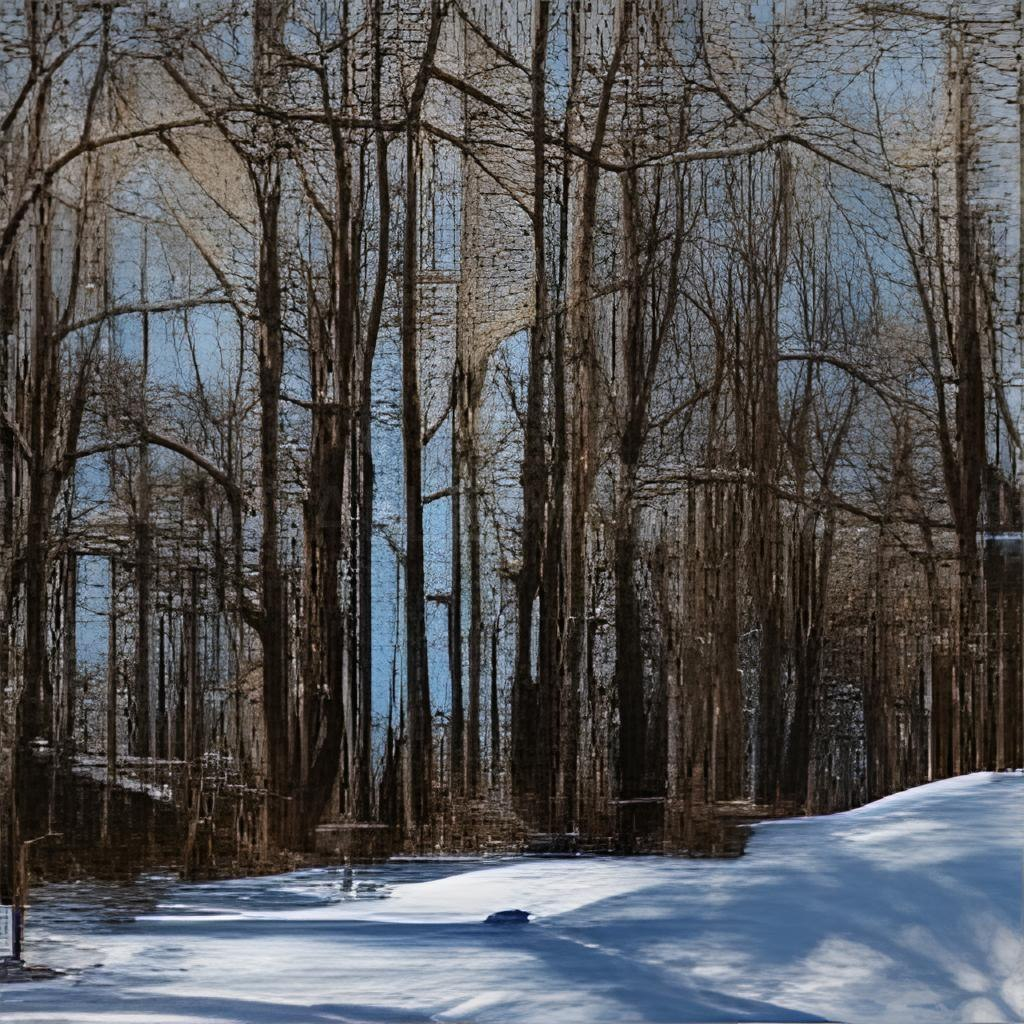

"Студент на защите диплома"

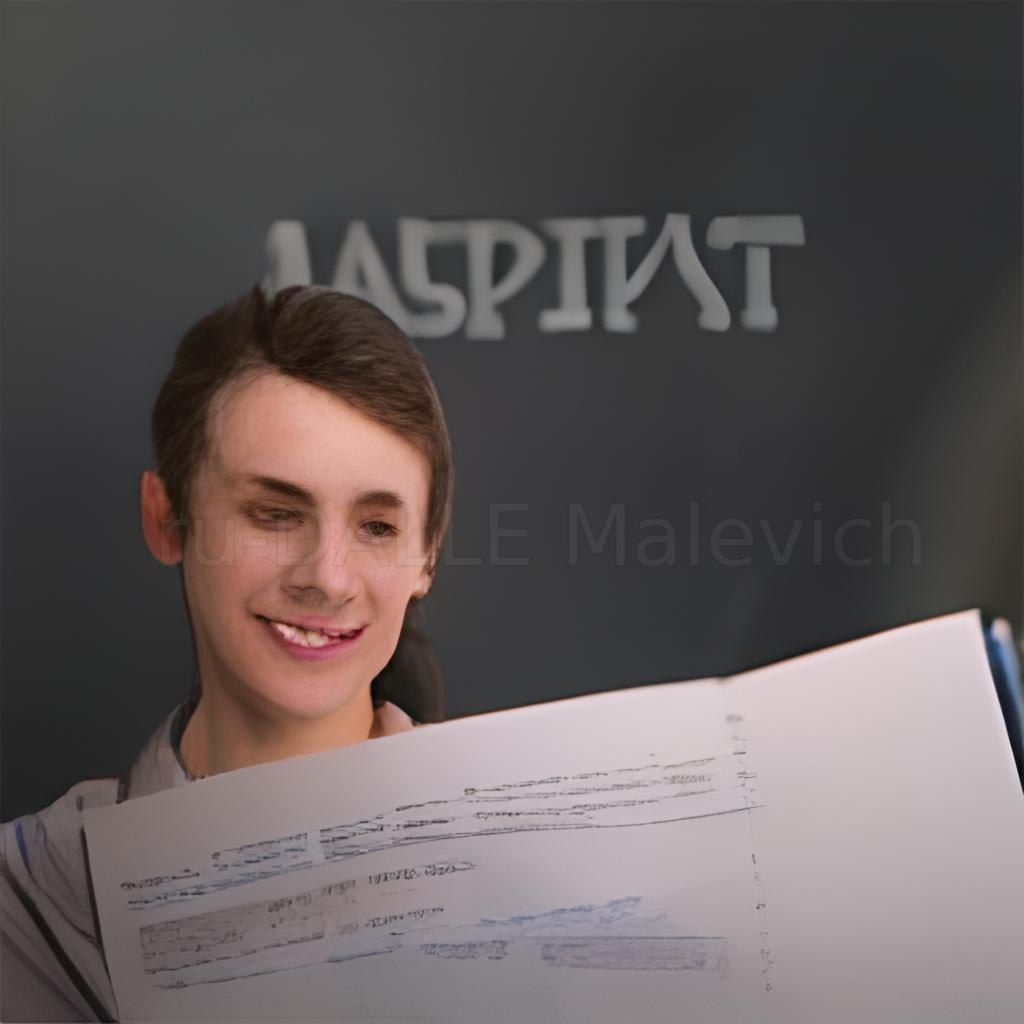